# Aprendizaje automático y aplicaciones

## Clasificación de imágenes con redes neuronales (caso de estudio)

---
$A^3$ @ FI-UNER : 2021

## Tarea a resolver

El objetivo es simple: lograr una red neuronal que pueda identificar dígitos manuscritos de números romanos.

In [1]:
# Imports básicos
from matplotlib import pyplot as plt
import numpy as np
import torch as tr
import pandas as pd 
import seaborn as sns 

## Exploracion del dataset

Contamos con un dataset (compilado por [Andrew Ng](https://worksheets.codalab.org/worksheets/0x7a8721f11e61436e93ac8f76da83f0e6)) con imágenes con los números entre 1 y 10. Si bien el problema parece sencillo, el dataset es bastante "natural", por lo que tendremos que invertir tiempo en prepararlo antes de usar un clasificador. 


Hay diferentes formas de levantar un dataset de imágenes. [Torchvision](https://pytorch.org/vision/stable/index.html) tiene herramientas para simplificar esta etapa. En muchos casos es posible que necesitemos tratar los datos de forma especial, y ahi es donde suele ser más conveniente hacer una clase Dataset como vimos en la clase pasada.


In [2]:
from torchvision.datasets import ImageFolder

# Esta clase hereda de Dataset y facilita levantar imagenes ordenadas en carpetas por clase. 
dataset = ImageFolder("train_dataset/")

print(dataset.classes)  
print(dataset.samples[0])  # primer elemento del dataset

# Notar que los indices en dataset.samples apuntan a dataset.clases. En este caso 'ix' tiene el valor 4 y 'v' el valor 5

['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']
('train_dataset/i/ab9fb784-ce5d-11eb-b317-38f9d35ea60f.png', 0)


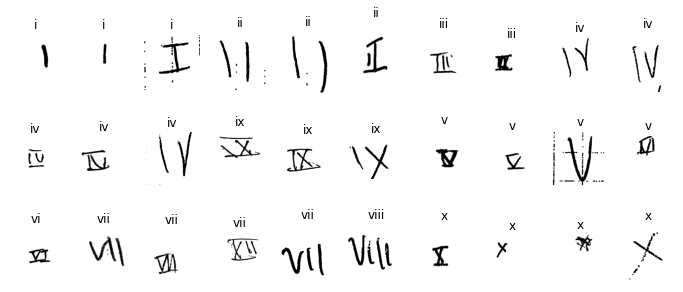

In [3]:
from PIL import Image


# Graficamos 30 ejemplos aleatoriamente
N = 30
fig, ax = plt.subplots(3, 10, figsize=(12, 5))
ax = ax.ravel()

ind = np.random.randint(0, len(dataset), N)

for k, i in enumerate(sorted(ind)):
    
    fname, label = dataset.samples[i]
    im = Image.open(fname)
    ax[k].imshow(im, cmap="gray")
    ax[k].set_title(dataset.classes[label])
    ax[k].axis("off")
    

Veamos como están distribuidos los datos 

In [4]:
details = []
for im, label in dataset:    
    
    intensity = np.mean(im)
    
    details.append([im.size[0], im.size[1], intensity, label])
details = pd.DataFrame(details, columns=["H", "W", "I", "label"])
print(details.describe())

                 H            W            I        label
count  2067.000000  2067.000000  2067.000000  2067.000000
mean    275.994678   253.555394   240.998920     4.319303
std      88.772769    68.728771     7.006597     2.844745
min     121.000000    88.000000   162.267532     0.000000
25%     231.000000   213.000000   237.196993     2.000000
50%     259.000000   253.000000   242.185339     4.000000
75%     291.000000   286.000000   245.700055     7.000000
max    1260.000000   616.000000   255.000000     9.000000


Siempre es buena idea revisar que no haya correlaciones espúreas en los 
datos que queremos clasificar. En este caso estamos viendo un resumen muy 
simple de los datos, pero sí hay diferencias importantes de escala por ejemplo,
seguramente estaremos introduciendo sesgos metodológicos si no las tenemos en cuenta

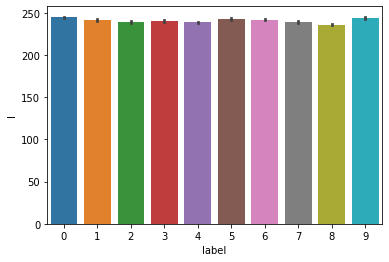

In [5]:
sns.barplot(data=details, x="label", y="I");

In [6]:
details.label.value_counts()

3    281
0    261
4    234
8    199
5    196
7    193
2    186
6    181
9    179
1    157
Name: label, dtype: int64

## Preprocesamiento 

Torchvision provee algunas herramientas que facilitan el manejo de imágenes. El módulo "transforms" es similar al pipeline de sklearn: se define un procedimiento paso a paso, y esto se aplica sobre cada imagen

https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

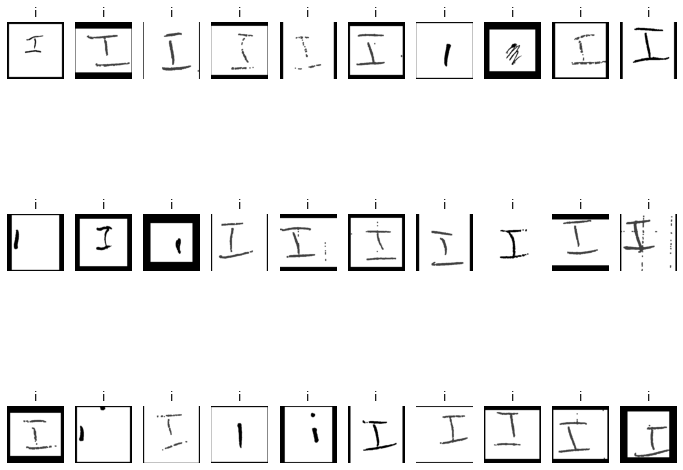

In [7]:
from torchvision import transforms

# Compose forma un "pipeline" de transformaciones
img_transforms = transforms.Compose([transforms.Grayscale(),
                                     transforms.CenterCrop(250),
                                     transforms.ToTensor()]) 

#img_transforms = transforms.Compose([transforms.Grayscale(),
#                                     transforms.RandomCrop(250, pad_if_needed=True, fill=255),
#                                     transforms.ToTensor()]) 

dataset = ImageFolder("train_dataset/", transform=img_transforms)

fig, ax = plt.subplots(3, 10, figsize=(12, 10))
ax = ax.ravel()

for k, (im, label) in enumerate(dataset):
    if k >= 30:
        break
    ax[k].imshow(im.squeeze(), cmap="gray")  # el tensor es de tamaño (C, H, W) 
    ax[k].set_title(dataset.classes[label])
    ax[k].axis("off")
    

## Definición de los dataloaders

In [8]:
from torch.utils.data import DataLoader

batch_size = 32
img_size = 250

train_transforms = transforms.Compose([transforms.Grayscale(),
                                       transforms.RandomAffine(degrees=20, 
                                                               scale=(0.8, 1.2), 
                                                               fill=255),  # Rotaciones y escalados aleatorios
                                       transforms.RandomCrop(img_size, 
                                                             pad_if_needed=True, 
                                                             fill=255),
                                       transforms.ToTensor()]) 

train_data = ImageFolder("train_dataset/", transform=train_transforms)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Para validación/test, usamos solo las transformaciones necesarias para llevar los datos a la misma escala 
test_transforms = transforms.Compose([transforms.Grayscale(),
                                      transforms.RandomCrop(img_size, 
                                                            pad_if_needed=True, 
                                                            fill=255),
                                      transforms.ToTensor()]) 

valid_data = ImageFolder("valid_dataset/", transform=test_transforms)
valid_loader = DataLoader(valid_data, batch_size=batch_size)



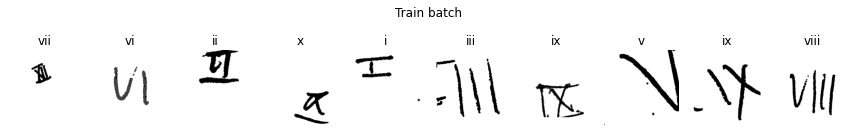

In [9]:
fig, ax = plt.subplots(1, 10, figsize=(12, 2))
ax = ax.ravel()
for batch_im, batch_label in train_loader:
    # grafico solo las primeras 10 imágenes del batch
    for k in range(10):
        ax[k].imshow(batch_im[k, :, :, :].squeeze(), cmap="gray")  # el tensor es de tamaño (C, H, W) 
        ax[k].set_title(train_data.classes[batch_label[k]])
        ax[k].axis("off")
    break
plt.suptitle("Train batch")    
plt.tight_layout()

In [10]:
batch_im.shape

torch.Size([32, 1, 250, 250])

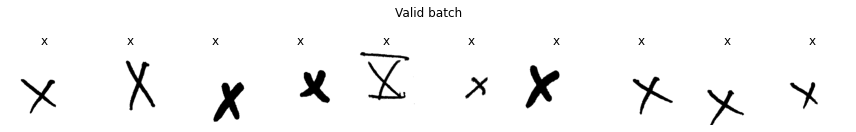

In [11]:
fig, ax = plt.subplots(1, 10, figsize=(12, 2))
ax = ax.ravel()
for batch_im, batch_label in valid_loader:
    # grafico solo las primeras 10 imágenes del batch
    for k in range(10):
        ax[k].imshow(batch_im[k, :, :, :].squeeze(), cmap="gray")  # el tensor es de tamaño (C, H, W) 
        ax[k].set_title(train_data.classes[batch_label[k]])
        ax[k].axis("off")
plt.suptitle("Valid batch")    
plt.tight_layout()

## Definición de la arquitectura

Para este problema vamos a usar una red convolucional de 2 dimensiones. La siguiente clase contine la red en si misma, el optimizador, la función de costo y las funciones auxiliares para entrenar y evaluar el modelo


In [12]:
from torch import nn, optim
from sklearn.metrics import balanced_accuracy_score

class CNN(nn.Module):
    '''
    Red neuronal convolucional 2D.    
    '''
    
    def __init__(self, input_size, i_channels, n_outputs, device):
        
        super(CNN, self).__init__()
        
        self.cnn = nn.Sequential(nn.Conv2d(i_channels, 32, kernel_size=3),
                                 nn.MaxPool2d(4),
                                 nn.ReLU(),
                                 nn.Conv2d(32, 64, kernel_size=3),
                                 nn.MaxPool2d(4),
                                 nn.ReLU(),
                                 nn.Conv2d(64, 128, kernel_size=3),
                                 nn.MaxPool2d(4),
                                 nn.ReLU()
                                )
            
        self.fc = nn.Linear(1152, n_outputs)
        #self.fc = nn.Linear(6272, n_outputs)
        
        self.loss_criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=1e-3)
        
        self.to(device)
        self.device = device

    def forward(self, x):
        
        y = self.cnn(x) # etapa convolucional
        y = self.fc(y.view(x.shape[0], -1)) # flatten y fully-connected

        return y  
    
    def train_step(self, dataloader):
        self.train()  
        cummulated_loss = 0
    
        for X, y in dataloader:

            self.optimizer.zero_grad()  
            y_pred = self(X.to(self.device))
            
            loss = self.loss_criterion(y_pred, y.to(self.device))
        
            cummulated_loss += loss.item() / len(dataloader)
        
            loss.backward()
            self.optimizer.step()
        
        return cummulated_loss
    
    
    def valid_step(self, dataloader):
        self.eval()  
        cummulated_loss = 0
        
        y_all, y_pred_all = [], []
        
        for X, y in dataloader:
          
            y_pred = self(X.to(self.device))
            
            # Acumulamos predicciones y etiquetas para calcular accuracy al final
            y_pred_all.append(tr.argmax(y_pred, axis=1).cpu().detach())
            y_all.append(y.cpu())
            
            loss = self.loss_criterion(y_pred, y.to(self.device))
        
            cummulated_loss += loss.item() / len(dataloader)
            
        
        bal_acc = balanced_accuracy_score(tr.cat(y_all), tr.cat(y_pred_all))
        return cummulated_loss, bal_acc


net = CNN(img_size, 1, 10, device="cuda")
net

CNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
  )
  (fc): Linear(in_features=1152, out_features=10, bias=True)
  (loss_criterion): CrossEntropyLoss()
)

## Entrenamiento

In [24]:
MAX_EPOCHS = 200
best_loss = 9999
model = CNN(img_size, 1, 10, device="cuda")

epoch = 0
counter = 0

log = {"train_loss": [], "valid_loss": [], "valid_bal_acc": []}

while (epoch < MAX_EPOCHS) and (counter < 20):
    
    #------------
    # TRAIN
    #------------
    train_loss = model.train_step(train_loader)
    valid_loss, valid_bal_acc = model.valid_step(valid_loader)
    
    log["train_loss"].append(train_loss)
    log["valid_loss"].append(valid_loss)
    log["valid_bal_acc"].append(valid_bal_acc)
    
    #=================================
    if (valid_loss < best_loss):
        
        # Actualizo best_loss
        best_loss = valid_loss
        best_epoch = epoch
        
        # Guardo mejor modelo
        best_model = model.state_dict()
        counter = 0
    else:
        counter += 1
    #=================================

    if epoch % 10 == 0:
        print(f"Epoch {epoch: 03d}: train loss {train_loss: .2f} | valid loss {valid_loss: .2f} | valid balanced accuracy {valid_bal_acc: .2f}")
    epoch += 1

tr.save(best_model, 'cnn2d.pmt')

/home/leandro/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch  00: train loss  2.26 | valid loss  2.24 | valid balanced accuracy  0.17
Epoch  10: train loss  1.08 | valid loss  1.05 | valid balanced accuracy  0.64
Epoch  20: train loss  0.90 | valid loss  0.92 | valid balanced accuracy  0.65
Epoch  30: train loss  0.73 | valid loss  0.73 | valid balanced accuracy  0.74
Epoch  40: train loss  0.67 | valid loss  0.77 | valid balanced accuracy  0.72
Epoch  50: train loss  0.63 | valid loss  0.72 | valid balanced accuracy  0.73
Epoch  60: train loss  0.61 | valid loss  0.73 | valid balanced accuracy  0.74
Epoch  70: train loss  0.54 | valid loss  0.76 | valid balanced accuracy  0.73
Epoch  80: train loss  0.50 | valid loss  0.69 | valid balanced accuracy  0.76


Text(0.5, 1.0, 'Balanced accuracy')

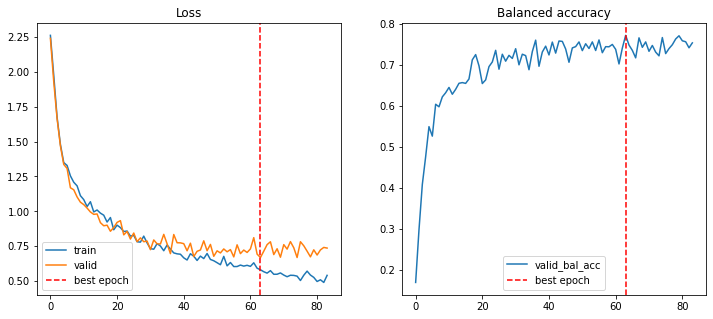

In [25]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(log["train_loss"], label="train")
plt.plot(log["valid_loss"], label="valid")
#plt.plot(best_epoch, [min(log["train_loss"]), max(log["train_loss"])])
plt.axvline(best_epoch, color="r", linestyle="--", label="best epoch")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(log["valid_bal_acc"], label="valid_bal_acc")
plt.axvline(best_epoch, color="r", linestyle="--", label="best epoch")
plt.legend()
plt.title("Balanced accuracy")


## Análisis de resultados

Vemos que la evaluación en train/validación parece razonable, ahora evaluamos en la partición de test

In [13]:
test_data = ImageFolder("test_dataset/", transform=test_transforms)
test_loader = DataLoader(valid_data, batch_size=batch_size)

# Cargamos el mejor modelo
model = CNN(img_size, 1, 10, device="cpu")
model.load_state_dict(tr.load("cnn2d.pmt"))

test_loss, test_bal_acc = model.valid_step(test_loader)
print(f"Test loss {test_loss: .3f}, Test balanced accuracy {test_bal_acc: .3f}")

/home/leandro/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test loss  0.755, Test balanced accuracy  0.707


En clasificación, la matriz de confusión nos da una mejor idea de que esta pasando

In [14]:
from sklearn.metrics import confusion_matrix

model.eval()
pred, labels = [], []
for img, label in test_loader:
    out = model(img).detach().cpu()
    
    labels.append(label)
    pred.append(tr.argmax(out, axis=1))
    
labels = tr.cat(labels)
pred = tr.cat(pred)
confm = confusion_matrix(labels, pred)

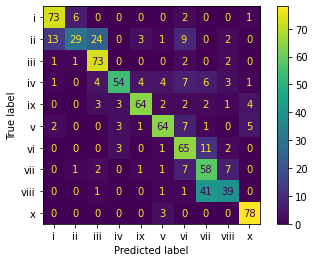

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confm, display_labels=dataset.classes).plot();